# Comparación de Modelos ResNet18 V2: Con y Sin BatchNorm/Dropout

Este notebook implementa y compara dos variantes de ResNet18 con arquitectura tipo embudo:
- **V2 SIN BatchNorm y SIN Dropout**: Solo capas Linear + ReLU
- **V2 CON BatchNorm y CON Dropout**: Con BatchNorm antes de ReLU y Dropout entre capas

Arquitectura tipo embudo: 512 → 256 → 128 → num_classes

In [1]:
# Import Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report

# Importar funciones de utilidad
from utils.data_proccess import create_dataloaders,create_transforms,load_datasets
from utils.train_model import train_model, plot_training_metrics
from utils.evaluate_model import evaluate_model
from utils.predict_images import predict_single_image

print("Librerías importadas exitosamente")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Librerías importadas exitosamente
PyTorch version: 2.9.1+cu128
CUDA available: True


In [2]:
# Load and Prepare Data
# Load and Prepare Data
print("Cargando y preparando datos...")

# Configuración de datos
data_dir = 'datos'  # Ajustar según tu estructura
batch_size = 32
image_size = 224

# Crear transforms usando la función de utilidad
train_transform, val_test_transform = create_transforms(img_size=image_size)

# Cargar datasets
train_dataset, val_dataset, test_dataset = load_datasets(data_dir, train_transform, val_test_transform)

# Crear dataloaders
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset,
    batch_size=batch_size
)

# Obtener nombres de clases
class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Número de clases: {num_classes}")
print(f"Clases: {class_names}")
print(f"Tamaño del dataset de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del dataset de validación: {len(val_dataset)}")
print(f"Tamaño del dataset de prueba: {len(test_dataset)}")

Cargando y preparando datos...
Número de clases: 5
Clases: ['carrot', 'chilli pepper', 'corn', 'cucumber', 'jalepeno']
Tamaño del dataset de entrenamiento: 438
Tamaño del dataset de validación: 47
Tamaño del dataset de prueba: 50


## Define Model Architecture V2 (Without BatchNorm and Dropout)

Arquitectura tipo embudo con solo capas Linear y activación ReLU:
- 512 → 256 → 128 → num_classes
- Sin BatchNorm
- Sin Dropout

In [3]:
class ResNet18V2_Sin(nn.Module):
    """
    ResNet18 V2 SIN BatchNorm y SIN Dropout
    Arquitectura tipo embudo: 512 → 256 → 128 → num_classes
    Solo Linear + ReLU
    """
    def __init__(self, num_classes):
        super(ResNet18V2_Sin, self).__init__()
        
        # Cargar ResNet18 preentrenado
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        # Congelar las capas del feature extractor
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        # Obtener el número de features del último layer
        num_features = self.resnet.fc.in_features
        
        # Reemplazar el clasificador con arquitectura tipo embudo
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        return self.resnet(x)

# Crear el modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v2_sin = ResNet18V2_Sin(num_classes).to(device)

print("Modelo V2 SIN BatchNorm/Dropout creado:")
print(f"Dispositivo: {device}")
print(f"Arquitectura del clasificador:")
print(model_v2_sin.resnet.fc)

Modelo V2 SIN BatchNorm/Dropout creado:
Dispositivo: cuda
Arquitectura del clasificador:
Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=128, out_features=5, bias=True)
)


## Define Model Architecture V2 (With BatchNorm and Dropout)

Misma arquitectura tipo embudo pero con:
- BatchNorm antes de ReLU en cada capa oculta
- Dropout entre 0.2 y 0.5 entre capas
- Activación ReLU

In [4]:
class ResNet18V2_Con(nn.Module):
    """
    ResNet18 V2 CON BatchNorm y CON Dropout
    Arquitectura tipo embudo: 512 → 256 → 128 → num_classes
    BatchNorm antes de ReLU, Dropout entre capas
    """
    def __init__(self, num_classes, dropout_rate=0.3):
        super(ResNet18V2_Con, self).__init__()
        
        # Cargar ResNet18 preentrenado
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        # Congelar las capas del feature extractor
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        # Obtener el número de features del último layer
        num_features = self.resnet.fc.in_features
        
        # Reemplazar el clasificador con arquitectura tipo embudo + BN + Dropout
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        return self.resnet(x)

# Crear el modelo
model_v2_con = ResNet18V2_Con(num_classes, dropout_rate=0.3).to(device)

print("Modelo V2 CON BatchNorm/Dropout creado:")
print(f"Dispositivo: {device}")
print(f"Arquitectura del clasificador:")
print(model_v2_con.resnet.fc)

Modelo V2 CON BatchNorm/Dropout creado:
Dispositivo: cuda
Arquitectura del clasificador:
Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): Dropout(p=0.3, inplace=False)
  (8): Linear(in_features=256, out_features=128, bias=True)
  (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Dropout(p=0.3, inplace=False)
  (12): Linear(in_features=128, out_features=5, bias=True)
)


## Training Setup and Configuration

Configuración del entrenamiento reutilizando los mismos parámetros:
- Criterion: CrossEntropyLoss
- Optimizer: Adam
- Early stopping: patience=5
- Inicialización de listas para tracking de pérdidas

In [5]:
# Training Setup and Configuration

# Configuración del entrenamiento
learning_rate = 0.001
num_epochs = 50
patience = 5

# Criterion (reutilizado para ambos modelos)
criterion = nn.CrossEntropyLoss()

# Optimizadores para cada modelo
optimizer_v2_sin = optim.Adam(model_v2_sin.parameters(), lr=learning_rate)
optimizer_v2_con = optim.Adam(model_v2_con.parameters(), lr=learning_rate)

# Inicializar listas para tracking de pérdidas
train_losses_v2_sin = []
val_losses_v2_sin = []
train_losses_v2_con = []
val_losses_v2_con = []

print("Configuración de entrenamiento:")
print(f"Learning rate: {learning_rate}")
print(f"Número máximo de épocas: {num_epochs}")
print(f"Early stopping patience: {patience}")
print(f"Criterion: {criterion}")
print(f"Optimizadores creados para ambos modelos")

Configuración de entrenamiento:
Learning rate: 0.001
Número máximo de épocas: 50
Early stopping patience: 5
Criterion: CrossEntropyLoss()
Optimizadores creados para ambos modelos


## Train Model V2 Without BatchNorm/Dropout

Entrenamiento del primer modelo usando las funciones de utilidad existentes.

In [6]:
print("=" * 60)
print("ENTRENANDO MODELO V2 SIN BatchNorm/Dropout")
print("=" * 60)

# Entrenar el modelo usando la función de utilidad
model_v2_sin, train_losses_v2_sin, val_losses_v2_sin, train_accuracies_v2_sin, val_accuracies_v2_sin, best_epoch_v2_sin = train_model(
    model=model_v2_sin,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_v2_sin,
    num_epochs=num_epochs,
    device=device,
    patience=patience
)

print(f"\nEntrenamiento completado!")
print(f"Total de épocas: {len(train_losses_v2_sin)}")
print(f"Mejor época: {best_epoch_v2_sin}")
print(f"Pérdida de entrenamiento final: {train_losses_v2_sin[-1]:.4f}")
print(f"Pérdida de validación final: {val_losses_v2_sin[-1]:.4f}")
print(f"Accuracy de entrenamiento final: {train_accuracies_v2_sin[-1]:.2f}%")
print(f"Accuracy de validación final: {val_accuracies_v2_sin[-1]:.2f}%")

ENTRENANDO MODELO V2 SIN BatchNorm/Dropout
Iniciando entrenamiento...
Device: cuda
Epochs maximos: 50
Early stopping patience: 5
------------------------------------------------------------
Epoch 1/50 - Batch 10/14 - Loss: 1.1471 - Acc: 41.88%
Epoch 1/50 completado en 9.50s
Train - Loss: 1.3316, Acc: 48.63%
Val   - Loss: 0.6503, Acc: 70.21%
🌟 Nuevo mejor modelo! Val Loss: 0.6503, Val Acc: 70.21%
------------------------------------------------------------
Epoch 2/50 - Batch 10/14 - Loss: 0.4406 - Acc: 76.56%
Epoch 2/50 completado en 9.05s
Train - Loss: 0.5990, Acc: 76.71%
Val   - Loss: 0.2917, Acc: 91.49%
🌟 Nuevo mejor modelo! Val Loss: 0.2917, Val Acc: 91.49%
------------------------------------------------------------
Epoch 3/50 - Batch 10/14 - Loss: 0.1972 - Acc: 81.25%
Epoch 3/50 completado en 9.13s
Train - Loss: 0.4557, Acc: 82.19%
Val   - Loss: 0.1428, Acc: 93.62%
🌟 Nuevo mejor modelo! Val Loss: 0.1428, Val Acc: 93.62%
------------------------------------------------------------


## Train Model V2 With BatchNorm/Dropout

Entrenamiento del segundo modelo usando la misma configuración.

In [7]:
# Train Model V2 With BatchNorm/Dropout
print("=" * 60)
print("ENTRENANDO MODELO V2 CON BatchNorm/Dropout")  # Corregido el título
print("=" * 60)

# Entrenar el modelo usando la función de utilidad
model_v2_con, train_losses_v2_con, val_losses_v2_con, train_accuracies_v2_con, val_accuracies_v2_con, best_epoch_v2_con = train_model(
    model=model_v2_con,  # Corregido: usar model_v2_con
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_v2_con,  # Corregido: usar optimizer_v2_con
    num_epochs=num_epochs,
    device=device,
    patience=patience
)

print(f"\nEntrenamiento completado!")
print(f"Total de épocas: {len(train_losses_v2_con)}")  # Corregido: usar variables _con
print(f"Mejor época: {best_epoch_v2_con}")
print(f"Pérdida de entrenamiento final: {train_losses_v2_con[-1]:.4f}")
print(f"Pérdida de validación final: {val_losses_v2_con[-1]:.4f}")
print(f"Accuracy de entrenamiento final: {train_accuracies_v2_con[-1]:.2f}%")
print(f"Accuracy de validación final: {val_accuracies_v2_con[-1]:.2f}%")

ENTRENANDO MODELO V2 CON BatchNorm/Dropout
Iniciando entrenamiento...
Device: cuda
Epochs maximos: 50
Early stopping patience: 5
------------------------------------------------------------
Epoch 1/50 - Batch 10/14 - Loss: 0.9697 - Acc: 48.12%
Epoch 1/50 completado en 9.06s
Train - Loss: 1.2065, Acc: 55.71%
Val   - Loss: 0.8504, Acc: 93.62%
🌟 Nuevo mejor modelo! Val Loss: 0.8504, Val Acc: 93.62%
------------------------------------------------------------
Epoch 2/50 - Batch 10/14 - Loss: 0.4493 - Acc: 88.44%
Epoch 2/50 completado en 8.97s
Train - Loss: 0.5982, Acc: 87.67%
Val   - Loss: 0.2639, Acc: 93.62%
🌟 Nuevo mejor modelo! Val Loss: 0.2639, Val Acc: 93.62%
------------------------------------------------------------
Epoch 3/50 - Batch 10/14 - Loss: 0.2610 - Acc: 90.31%
Epoch 3/50 completado en 9.00s
Train - Loss: 0.4242, Acc: 89.95%
Val   - Loss: 0.1640, Acc: 95.74%
🌟 Nuevo mejor modelo! Val Loss: 0.1640, Val Acc: 95.74%
------------------------------------------------------------


## Evaluate Model V2 Without BatchNorm/Dropout

Evaluación del primer modelo: matriz de confusión y classification report.

EVALUACIÓN MODELO V2 SIN BatchNorm/Dropout
Evaluando modelo en conjunto de test...

Resultados de evaluacion:
Accuracy total: 0.9600 (96.00%)
Muestras correctas: 48/50


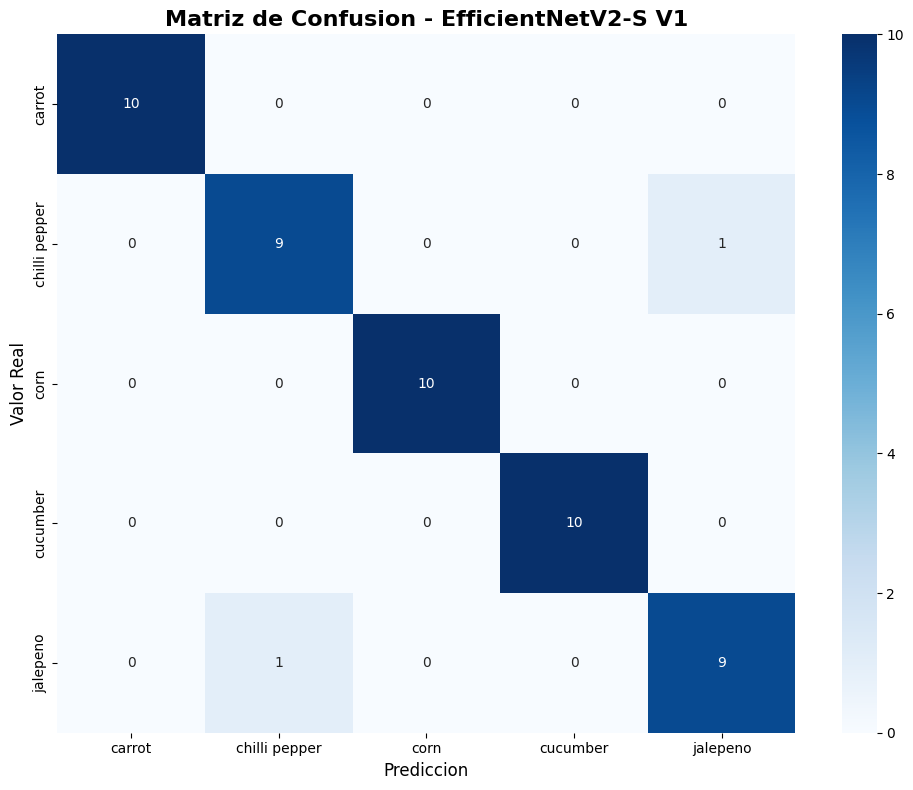


Reporte de Clasificacion:
------------------------------------------------------------
               precision    recall  f1-score   support

       carrot     1.0000    1.0000    1.0000        10
chilli pepper     0.9000    0.9000    0.9000        10
         corn     1.0000    1.0000    1.0000        10
     cucumber     1.0000    1.0000    1.0000        10
     jalepeno     0.9000    0.9000    0.9000        10

     accuracy                         0.9600        50
    macro avg     0.9600    0.9600    0.9600        50
 weighted avg     0.9600    0.9600    0.9600        50


Accuracy V2 Sin BatchNorm/Dropout: 0.9600


In [8]:
# Evaluate Model V2 Without BatchNorm/Dropout
print("=" * 60)
print("EVALUACIÓN MODELO V2 SIN BatchNorm/Dropout")
print("=" * 60)

# Evaluar el modelo usando las funciones de utilidad (corregido: agregar class_names)
accuracy_sin, y_true_sin, y_pred_sin = evaluate_model(
    model=model_v2_sin,  
    test_loader=test_loader,
    class_names=class_names,  # Agregar class_names como parámetro
    device=device
)

print(f"\nAccuracy V2 Sin BatchNorm/Dropout: {accuracy_sin:.4f}")

## Evaluate Model V2 With BatchNorm/Dropout

Evaluación del segundo modelo: matriz de confusión y classification report.

EVALUACIÓN MODELO V2 CON BatchNorm/Dropout
Evaluando modelo en conjunto de test...

Resultados de evaluacion:
Accuracy total: 1.0000 (100.00%)
Muestras correctas: 50/50


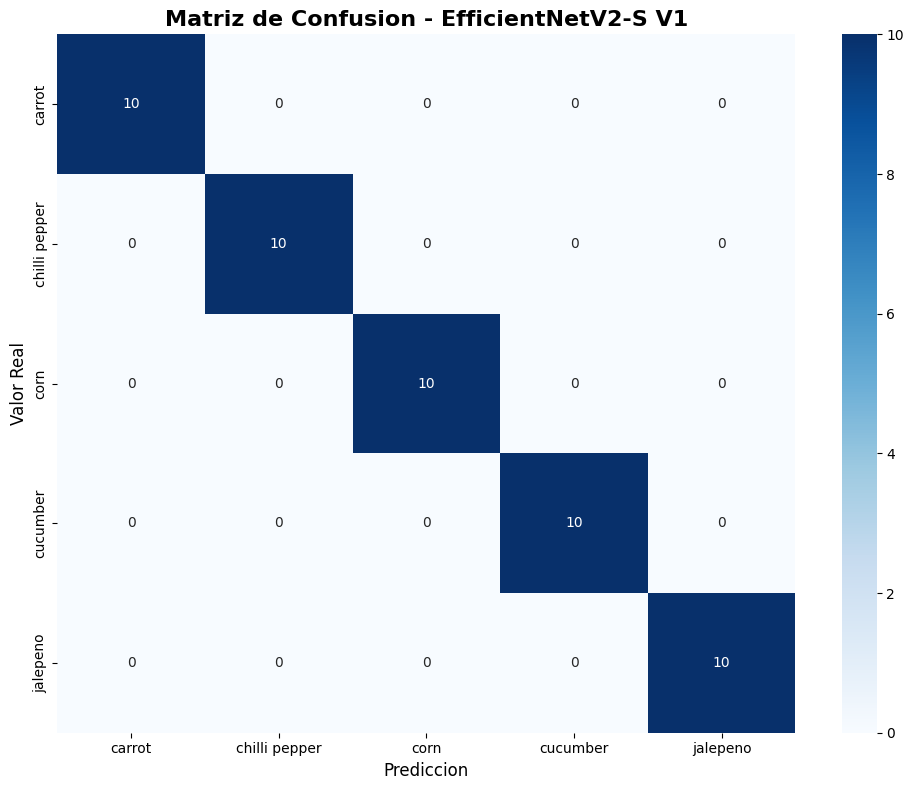


Reporte de Clasificacion:
------------------------------------------------------------
               precision    recall  f1-score   support

       carrot     1.0000    1.0000    1.0000        10
chilli pepper     1.0000    1.0000    1.0000        10
         corn     1.0000    1.0000    1.0000        10
     cucumber     1.0000    1.0000    1.0000        10
     jalepeno     1.0000    1.0000    1.0000        10

     accuracy                         1.0000        50
    macro avg     1.0000    1.0000    1.0000        50
 weighted avg     1.0000    1.0000    1.0000        50


Accuracy V2 Con BatchNorm/Dropout: 1.0000


In [9]:
# Evaluate Model V2 With BatchNorm/Dropout
print("=" * 60)
print("EVALUACIÓN MODELO V2 CON BatchNorm/Dropout")
print("=" * 60)

# Evaluar el modelo usando las funciones de utilidad (corregido: agregar class_names)
accuracy_con, y_true_con, y_pred_con = evaluate_model(
    model=model_v2_con,
    test_loader=test_loader,
    class_names=class_names,  # Agregar class_names como parámetro
    device=device
)

print(f"\nAccuracy V2 Con BatchNorm/Dropout: {accuracy_con:.4f}")

## Compare Training Curves

Visualización y comparación de las curvas de pérdida de entrenamiento y validación para ambos modelos.


Visualizando métricas V2 SIN BatchNorm/Dropout:


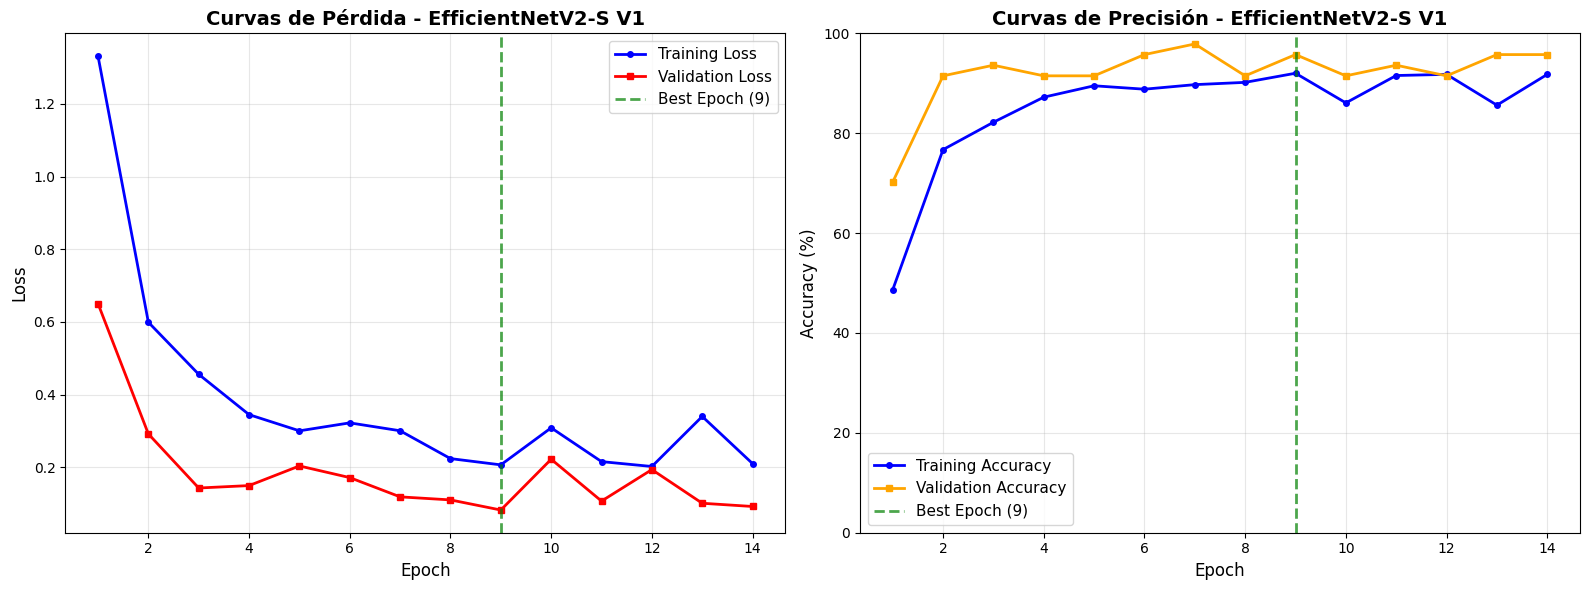

📊 RESUMEN DE MÉTRICAS:
📈 LOSS:
  • Final training loss:     0.2099
  • Final validation loss:   0.0919
  • Best validation loss:    0.0822 (epoch 9)
📊 ACCURACY:
  • Final training accuracy:     91.78%
  • Final validation accuracy:   95.74%
  • Best validation accuracy:    97.87% (epoch 7)
⭐ MEJOR MODELO (Epoch 9):
  • Validation loss:     0.0822
  • Validation accuracy: 95.74%


In [10]:
# Visualizar curvas de entrenamiento V2 Sin BatchNorm/Dropout
print("\nVisualizando métricas V2 SIN BatchNorm/Dropout:")
plot_training_metrics(
    train_losses_v2_sin, 
    val_losses_v2_sin, 
    train_accuracies_v2_sin, 
    val_accuracies_v2_sin, 
    best_epoch_v2_sin
)


Visualizando métricas V2 CON BatchNorm/Dropout:


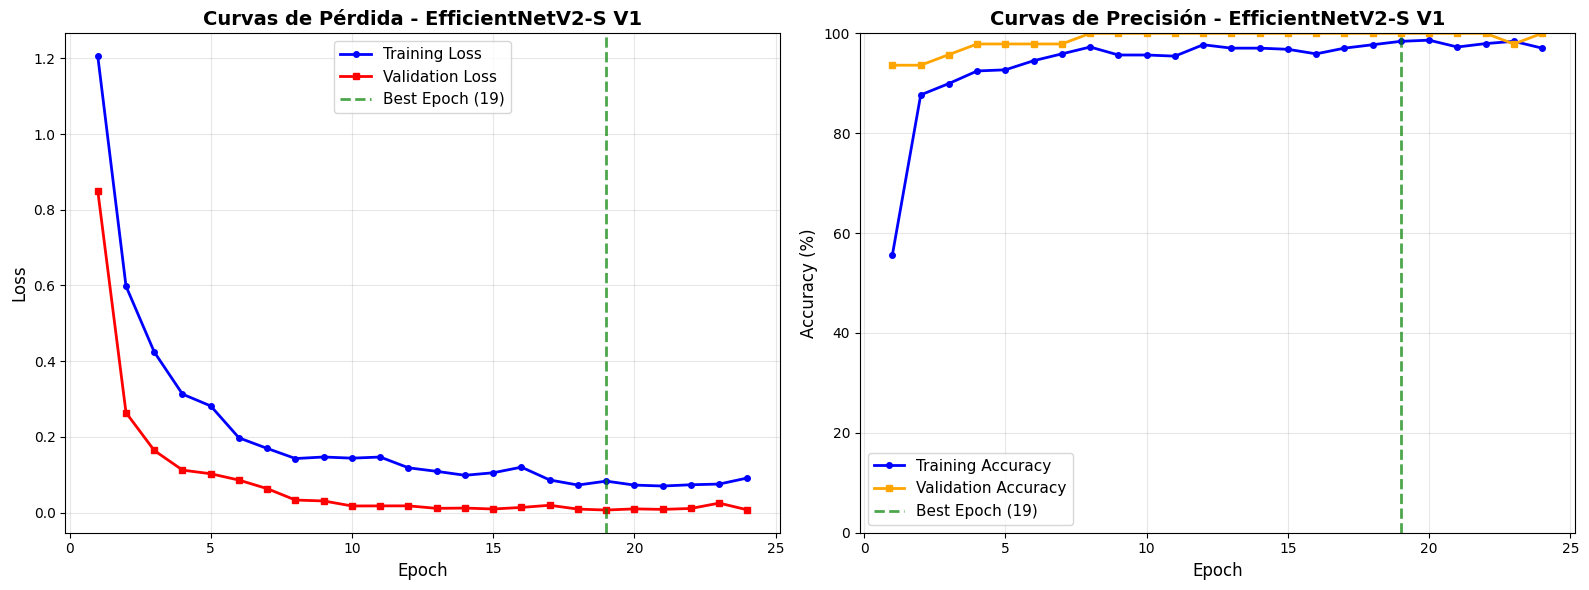

📊 RESUMEN DE MÉTRICAS:
📈 LOSS:
  • Final training loss:     0.0912
  • Final validation loss:   0.0070
  • Best validation loss:    0.0066 (epoch 19)
📊 ACCURACY:
  • Final training accuracy:     97.03%
  • Final validation accuracy:   100.00%
  • Best validation accuracy:    100.00% (epoch 8)
⭐ MEJOR MODELO (Epoch 19):
  • Validation loss:     0.0066
  • Validation accuracy: 100.00%


In [11]:
# Visualizar curvas de entrenamiento V2 Con BatchNorm/Dropout
print("\nVisualizando métricas V2 CON BatchNorm/Dropout:")
plot_training_metrics(
    train_losses_v2_con, 
    val_losses_v2_con, 
    train_accuracies_v2_con, 
    val_accuracies_v2_con, 
    best_epoch_v2_con
)

In [12]:
# Comparación final de ambos modelos
print("=" * 80)
print("ANÁLISIS COMPARATIVO FINAL")
print("=" * 80)

print("\n📊 RESUMEN DE RESULTADOS:")
print("-" * 50)
print(f"{'Modelo':<30} {'Test Accuracy':<15} {'Best Epoch':<12}")
print("-" * 50)
print(f"{'V2 Sin BatchNorm/Dropout':<30} {accuracy_sin:.4f} ({accuracy_sin*100:.2f}%){'':<3} {best_epoch_v2_sin:<12}")
print(f"{'V2 Con BatchNorm/Dropout':<30} {accuracy_con:.4f} ({accuracy_con*100:.2f}%){'':<3} {best_epoch_v2_con:<12}")
print("-" * 50)

print("\n🔍 ANÁLISIS:")
if accuracy_con > accuracy_sin:
    print(f"✅ El modelo CON BatchNorm/Dropout tuvo mejor accuracy ({accuracy_con:.4f} vs {accuracy_sin:.4f})")
else:
    print(f"✅ El modelo SIN BatchNorm/Dropout tuvo mejor accuracy ({accuracy_sin:.4f} vs {accuracy_con:.4f})")

if best_epoch_v2_con < best_epoch_v2_sin:
    print(f"⚡ El modelo CON BatchNorm/Dropout convergió más rápido (época {best_epoch_v2_con} vs {best_epoch_v2_sin})")
else:
    print(f"⚡ El modelo SIN BatchNorm/Dropout convergió más rápido (época {best_epoch_v2_sin} vs {best_epoch_v2_con})")

ANÁLISIS COMPARATIVO FINAL

📊 RESUMEN DE RESULTADOS:
--------------------------------------------------
Modelo                         Test Accuracy   Best Epoch  
--------------------------------------------------
V2 Sin BatchNorm/Dropout       0.9600 (96.00%)    9           
V2 Con BatchNorm/Dropout       1.0000 (100.00%)    19          
--------------------------------------------------

🔍 ANÁLISIS:
✅ El modelo CON BatchNorm/Dropout tuvo mejor accuracy (1.0000 vs 0.9600)
⚡ El modelo SIN BatchNorm/Dropout convergió más rápido (época 9 vs 19)
